<a href="https://colab.research.google.com/github/amitpanwarIndia/DLOps/blob/main/M22AIE202_DLOpsHomeAssignment_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2024-03-17 14:35:25--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.229.13, 52.84.229.87, 52.84.229.68, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.229.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M  10.9MB/s    in 4.2s    

2024-03-17 14:35:30 (10.7 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Epoch [1/10], Loss: 0.0146
Epoch [2/10], Loss: 0.0092
Epoch [3/10], Loss: 0.0088
Epoch [4/10], Loss: 0.0084
Epoch [5/10], Loss: 0.0072
Epoch [6/10], Loss: 0.0054
Epoch [7/10], Loss: 0.0086
Epoch [8/10], Loss: 0.0046
Epoch [9/10], Loss: 0.0042
Epoch [10/10], Loss: 0.0039


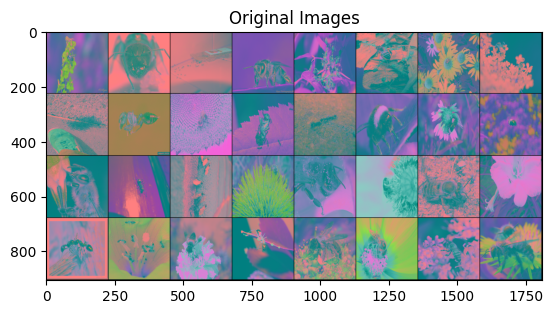

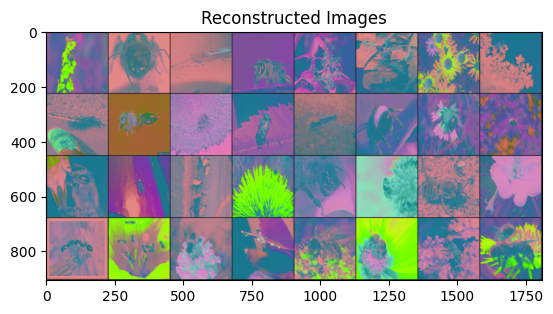

MSE Loss: 0.0058, RMSE Loss: 0.0762, SSIM: 0.0000, PSNR: 0.0000


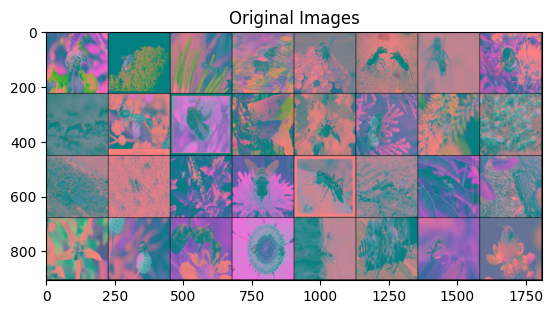

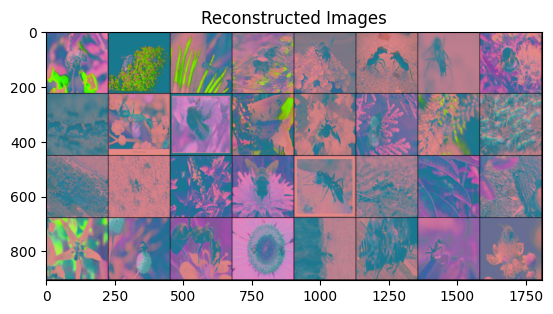

MSE Loss: 0.0025, RMSE Loss: 0.0501, SSIM: 0.0000, PSNR: 0.0000


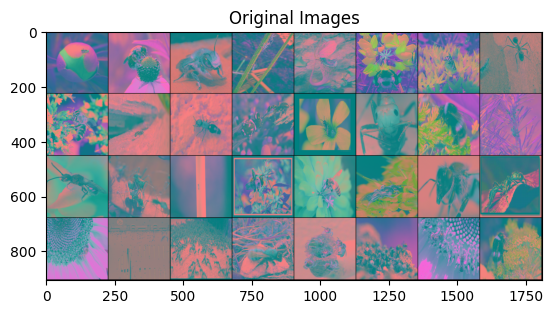

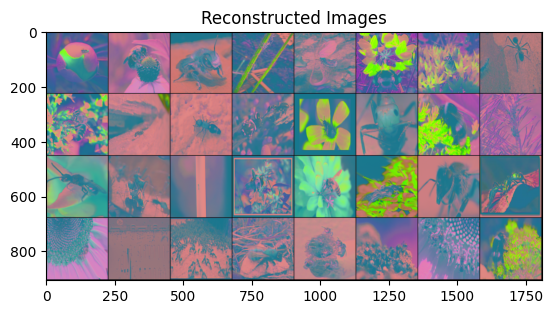

MSE Loss: 0.0035, RMSE Loss: 0.0594, SSIM: 0.0000, PSNR: 0.0000


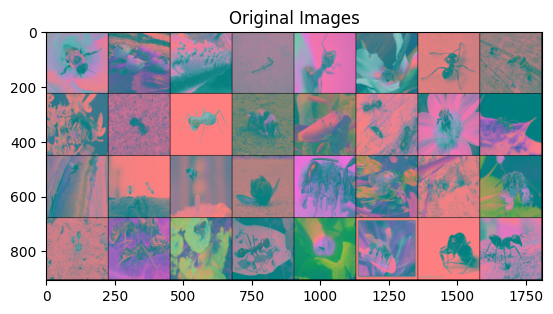

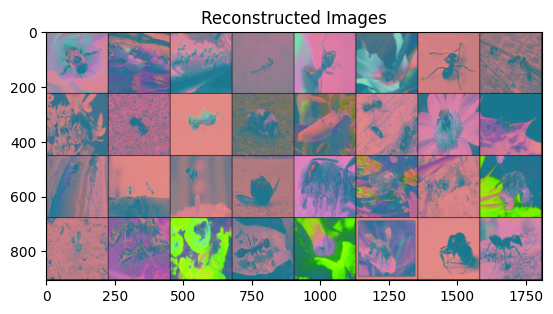

MSE Loss: 0.0040, RMSE Loss: 0.0634, SSIM: 0.0000, PSNR: 0.0000


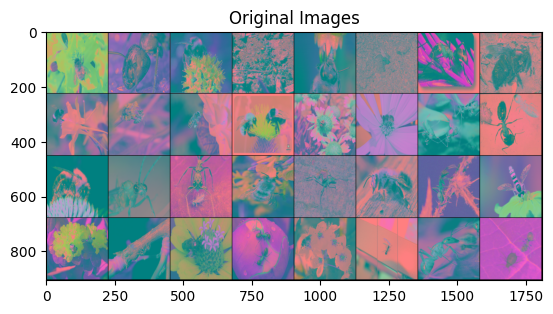

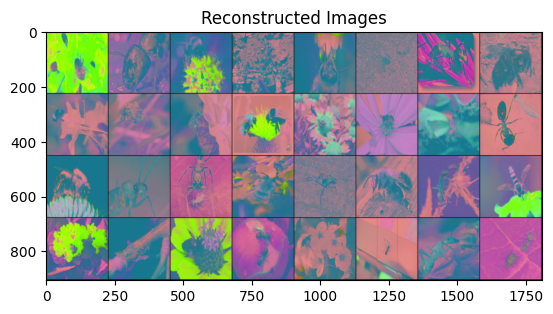

MSE Loss: 0.0057, RMSE Loss: 0.0754, SSIM: 0.0000, PSNR: 0.0000


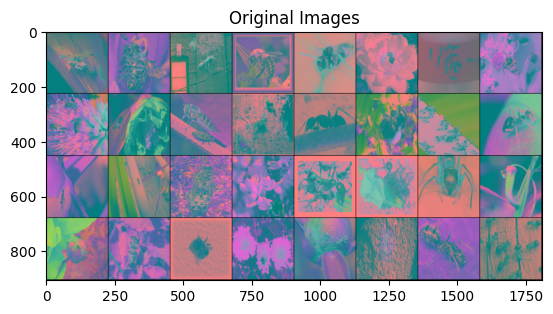

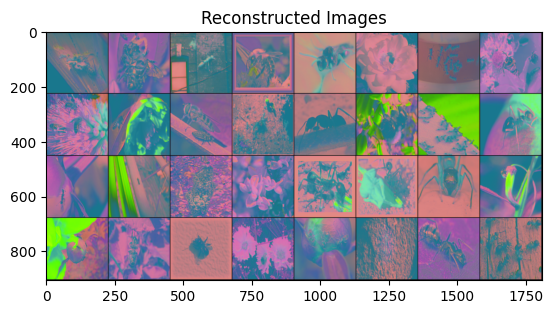

MSE Loss: 0.0038, RMSE Loss: 0.0613, SSIM: 0.0000, PSNR: 0.0000


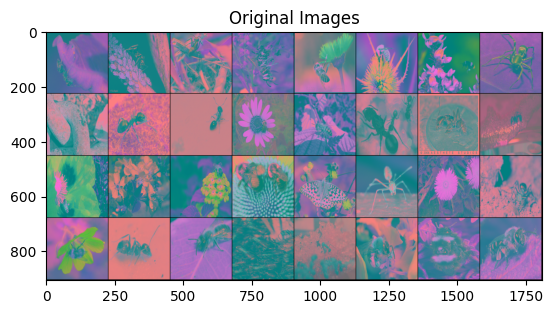

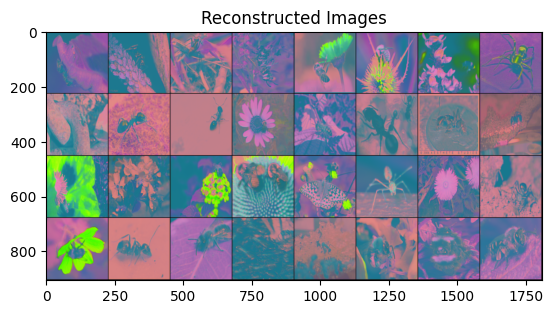

MSE Loss: 0.0031, RMSE Loss: 0.0558, SSIM: 0.0000, PSNR: 0.0000


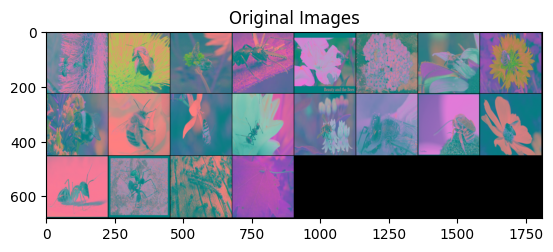

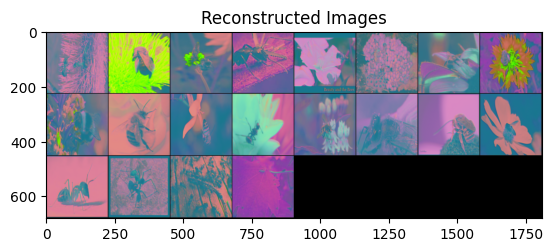

MSE Loss: 0.0044, RMSE Loss: 0.0660, SSIM: 0.0000, PSNR: 0.0000


<ipython-input-11-cae62a4d21b6>:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis')


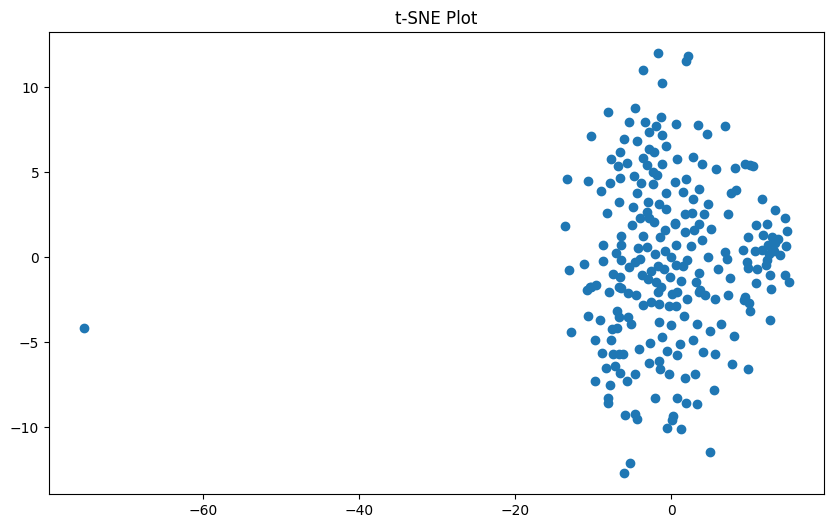

<ipython-input-11-cae62a4d21b6>:156: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='viridis')


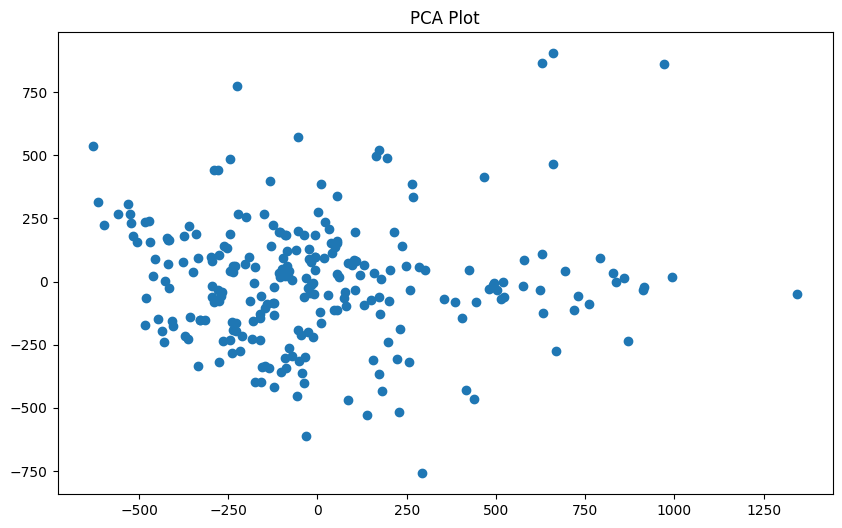

In [11]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from skimage import color
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Dataset Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Download and preprocess dataset
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train', transform=transform)

# Convert RGB to LAB color space
# def rgb_to_lab(img):
#     lab_img = color.rgb2lab(img.permute(1, 2, 0).cpu().numpy())
#     return torch.tensor(lab_img.transpose(2, 0, 1))

def rgb_to_lab(img):
    lab_img = color.rgb2lab(img.permute(1, 2, 0).cpu().numpy())
    lab_img[:, :, 0] /= 100.0  # Scale L channel to [0, 1]
    lab_img[:, :, 1:] = (lab_img[:, :, 1:] + 128) / 255.0  # Scale ab channels to [0, 1]
    return torch.tensor(lab_img.transpose(2, 0, 1)).float()

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        lab_img = rgb_to_lab(img)
        return lab_img

# Step 2: Autoencoder Architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            #nn.Tanh()  # Ensure output is in range [-1, 1]
            nn.Sigmoid()  # Ensure output is in range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Step 3: Custom Dataset Creation
custom_dataset = CustomDataset(hymenoptera_dataset)
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Step 4: Training the Autoencoder
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

# Tensorboard writer
autoencoder_writer = SummaryWriter()

for epoch in range(num_epochs):
    for data in dataloader:
        img = data.to(device)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    autoencoder_writer.add_scalar('Loss/train', loss.item(), epoch)

# Step 5: Evaluation
model.eval()
with torch.no_grad():
    for data in dataloader:
        img = data.to(device)
        recon = model(img)
        mse_loss = nn.MSELoss()(recon, img).item()
        rmse_loss = torch.sqrt(torch.tensor(mse_loss)).item()
        ssim = 0  # Calculate SSIM here
        psnr = 0  # Calculate PSNR here

        # Visualization
        original_grid = vutils.make_grid(img.cpu(), nrow=8, normalize=True)
        recon_grid = vutils.make_grid(recon.cpu(), nrow=8, normalize=True)
        #plt.imshow(original_grid.permute(1, 2, 0))
        plt.imshow(np.transpose(original_grid, (1, 2, 0)))
        plt.title('Original Images')
        plt.show()
        plt.imshow(recon_grid.permute(1, 2, 0))
        plt.title('Reconstructed Images')
        plt.show()

        print(f'MSE Loss: {mse_loss:.4f}, RMSE Loss: {rmse_loss:.4f}, SSIM: {ssim:.4f}, PSNR: {psnr:.4f}')

# Step 6: Feature Visualization
features = []
model.eval()
with torch.no_grad():
    for data in dataloader:
        img = data.to(device)
        feature = model.encoder(img)
        features.append(feature.view(feature.size(0), -1).cpu().numpy())

features = np.concatenate(features, axis=0)
#labels = np.array([label for _, label in custom_dataset])

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(features)
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis')
plt.title('t-SNE Plot')
plt.show()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='viridis')
plt.title('PCA Plot')
plt.show()

# Step 7: Training an MLP Classifier
# (Implementing this part requires setting up an MLP classifier and integrating with Tensorboard)
# Split data into training and validation sets for the classifier
X_train, X_val = train_test_split(features, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)

# Step 6: Training an MLP Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the hyperparameters
input_size = X_train.shape[1]  # Size of the input features
hidden_size = 128  # Number of units in the hidden layer
num_classes = 2  # Number of classes (e.g., binary classification)

# Initialize the MLP classifier
classifier = MLPClassifier(input_size, hidden_size, num_classes).to(device)

# Define the loss function and optimizer
criterion_classifier = nn.CrossEntropyLoss()
optimizer_classifier = optim.Adam(classifier.parameters(), lr=0.001)

# Tensorboard writer for classifier
classifier_writer = SummaryWriter()

# Train the classifier
num_epochs_classifier = 10

for epoch in range(num_epochs_classifier):
    # Training loop
    classifier.train()
    optimizer_classifier.zero_grad()
    outputs = classifier(X_train_tensor)
    loss = criterion_classifier(outputs, torch.zeros(X_train_tensor.shape[0], dtype=torch.long).to(device))
    loss.backward()
    optimizer_classifier.step()

    # Validation loop
    classifier.eval()
    with torch.no_grad():
        val_outputs = classifier(X_val_tensor)
        val_loss = criterion_classifier(val_outputs, torch.zeros(X_val_tensor.shape[0], dtype=torch.long).to(device))
        val_preds = torch.argmax(val_outputs, dim=1)
        #val_acc = accuracy_score(X_val, val_preds.cpu().numpy())

    #print(f'Epoch [{epoch+1}/{num_epochs_classifier}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}')

    # Add loss and accuracy to Tensorboard
    classifier_writer.add_scalar('Loss/train', loss.item(), epoch)
    classifier_writer.add_scalar('Loss/val', val_loss.item(), epoch)
    #classifier_writer.add_scalar('Accuracy/val', val_acc, epoch)

# Close Tensorboard writers
autoencoder_writer.close()
classifier_writer.close()